In [1]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import cv2
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)

set_seed(42)

# Preprocessing
Includes:
- Resizing images
- Augmentation
  - Rotation
  - Flipping vertically
  - Brightness adjustments
  - Contrast
  - Color enhancement

In [3]:
IMAGES_PATH = 'data/head_ct/'
LABELS_PATH = 'data/labels.csv'

## Loading labels

In [4]:
labels = pd.read_csv(LABELS_PATH)
labels.head()

,id,hemorrhage
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


The 2nd column name has an error: ' ' (space) in front of `hemorrhage`.

So instead of `hemorrhage` there is `_hemorrhage`

In [5]:
labels.rename(columns={' hemorrhage': 'hemorrhage'}, inplace=True)
labels.head()

,id,hemorrhage
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


## Loading images 
and resizing them accordingly

In [6]:
images = []
for file in os.listdir(IMAGES_PATH):
    if file.endswith('.png'):
        images.append(IMAGES_PATH + file)
        

In [7]:
len(images)

200

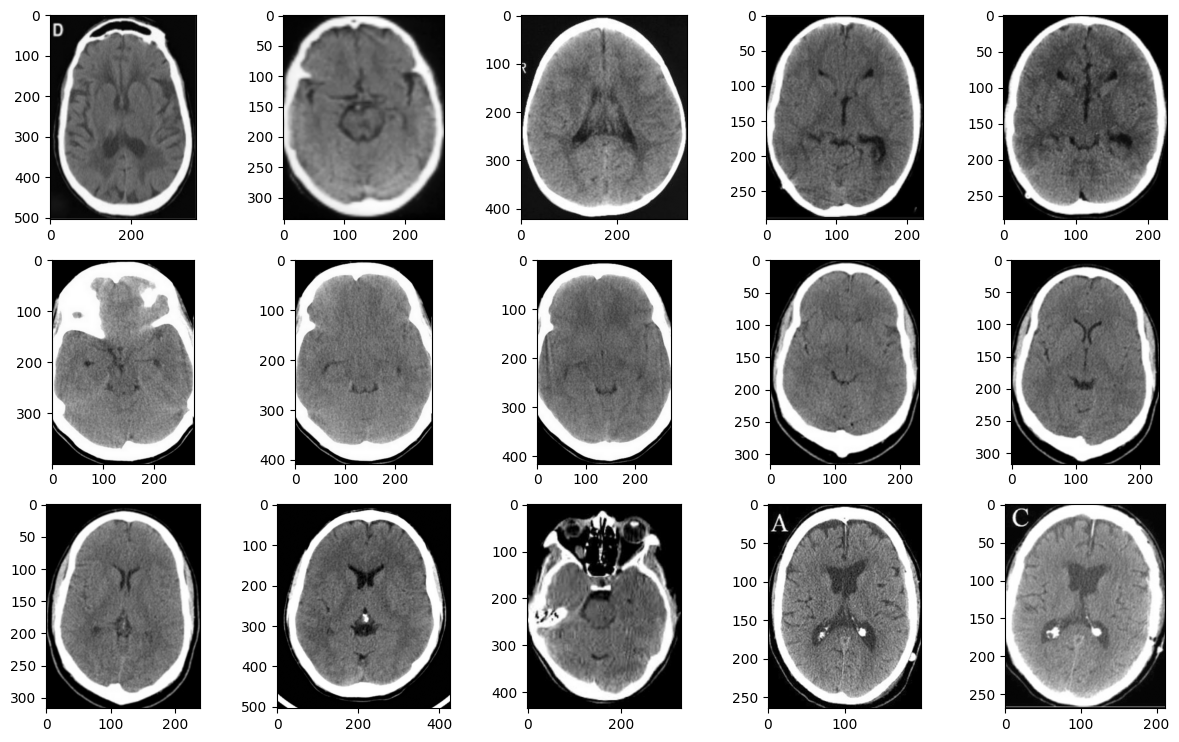

In [8]:
# Display example of normal images
normal = labels[labels['hemorrhage'] == 0]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    image = cv2.imread(images[normal.index[i]], cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
plt.show()


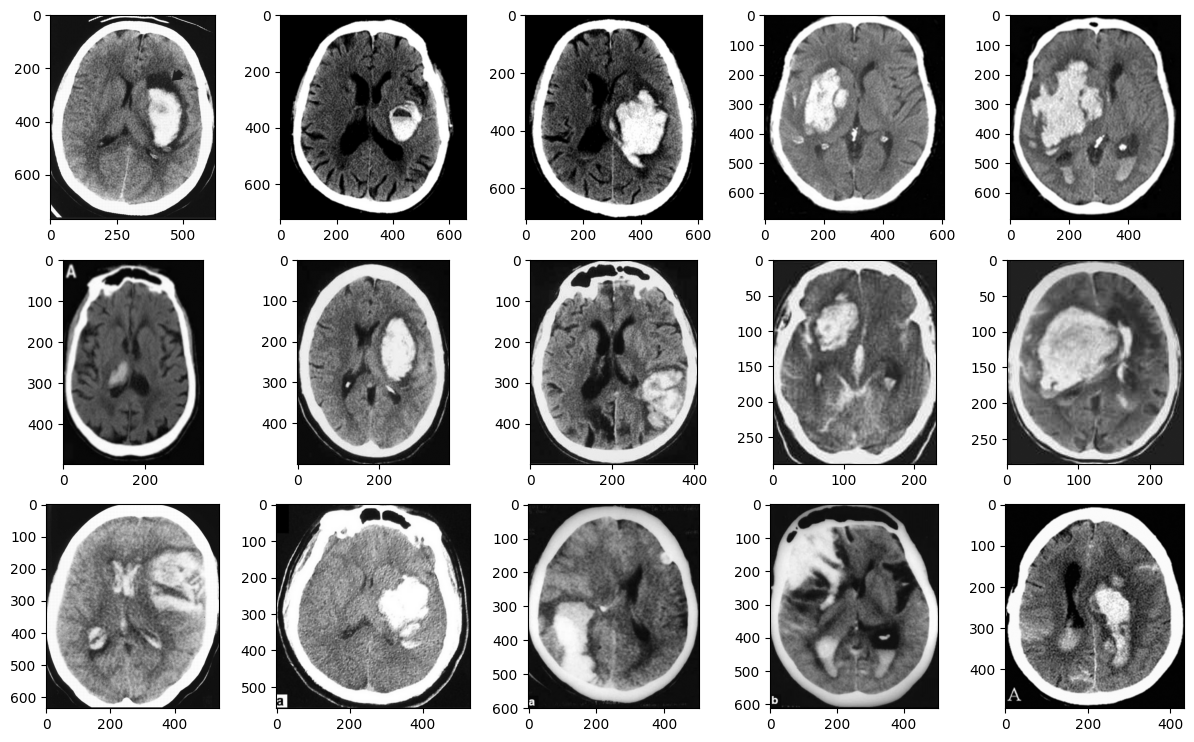

In [9]:
# Display example of images with hemorrhage
hemorrhage = labels[labels['hemorrhage'] == 1]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    image = cv2.imread(images[hemorrhage.index[i]], cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
plt.show()

Since we have small dataset, to improve accuracy, we have to apply data augmentation.
It helps with:
- **Prevents overfitting** - model learns from features rather than memorizing?
- **Improves robustness** - real data are not perfect, so simple rotations or vertical (not horizontal!) flips are helpful
- **Simulates real life condition**

Source: https://pmc.ncbi.nlm.nih.gov/articles/PMC10027281/#Tab1

In [10]:
def apply_augmentation(image):
    
    angle=random.randint(-20,20)
    augmented_image=image.rotate(angle)
    
    if(random.random()>0.5):
        augmented_image=augmented_image.transpose(Image.FLIP_LEFT_RIGHT)
    
    brightness_factor=random.uniform(0.85,1.15)
    enhanced_image= ImageEnhance.Brightness(augmented_image).enhance(brightness_factor)
    
    contrast_factor = random.uniform(0.85, 1.15)
    enhanced_image = ImageEnhance.Contrast(enhanced_image).enhance(contrast_factor)
    
    color_image = ImageEnhance.Color(enhanced_image).enhance(random.uniform(0.8, 1.2))
    
    # nearest-neighbor
    
    scale_factor=random.uniform(0.8,1.2)
    new_size=(int(color_image.width * scale_factor),int(color_image.height * scale_factor))
    
    new_image=color_image.resize(new_size,Image.NEAREST)
    
    
    return new_image

In [11]:
# Augmenting the dataset
augmented_images = []
augmented_labels = pd.DataFrame(columns=['id', 'hemorrhage'])

AUGMENTATIONS_PER_IMAGE = 5

for image in images:
    for i in range(AUGMENTATIONS_PER_IMAGE):
        pil_image = Image.open(image)
        augmented_image = apply_augmentation(pil_image)
        augmented_images.append(augmented_image)
        
        # Get the label for the original image
        image_index = images.index(image)
        label = labels.iloc[image_index]['hemorrhage']

        augmented_labels.loc[len(augmented_labels)] = [f"A{i:03d}",label] # in case of saving the image, the label is set here


In [12]:
augmented_labels.head()

,id,hemorrhage
0,A000,1
1,A001,1
2,A002,1
3,A003,1
4,A004,1


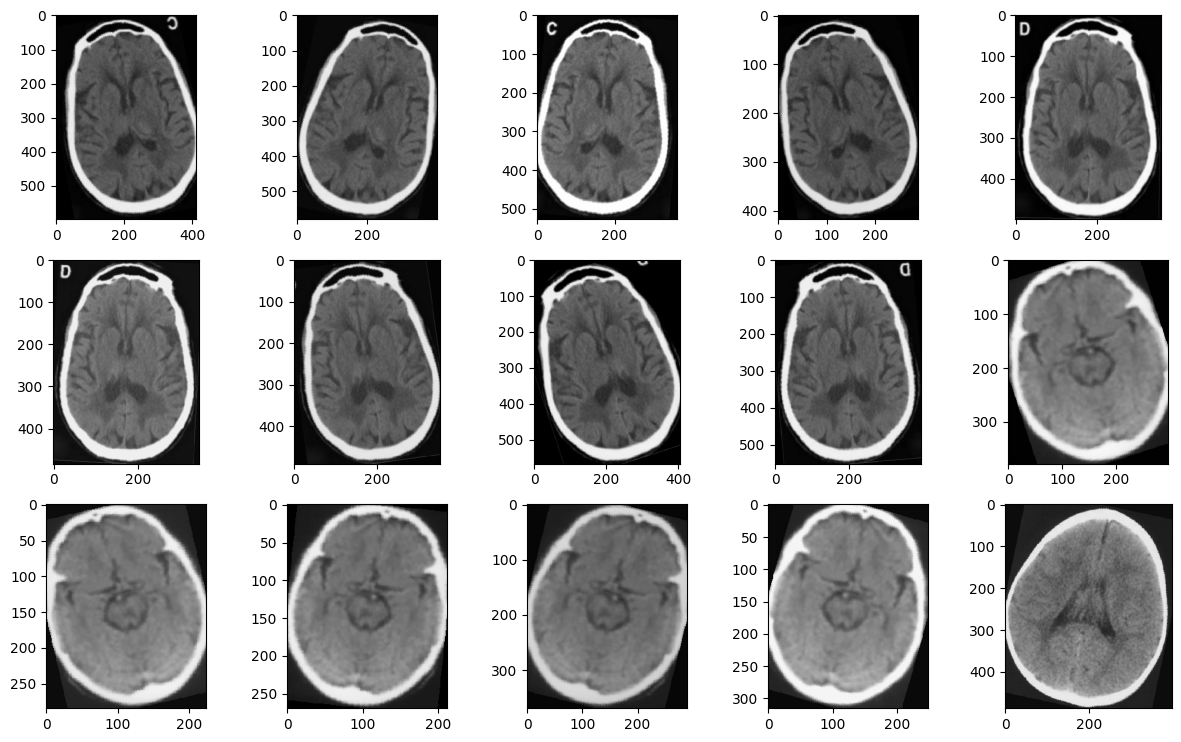

In [13]:
# Display example of augmented images without hemorrhage
hemorrhage = augmented_labels[augmented_labels['hemorrhage'] == 0]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(augmented_images[hemorrhage.index[i]], cmap='gray')
plt.show()

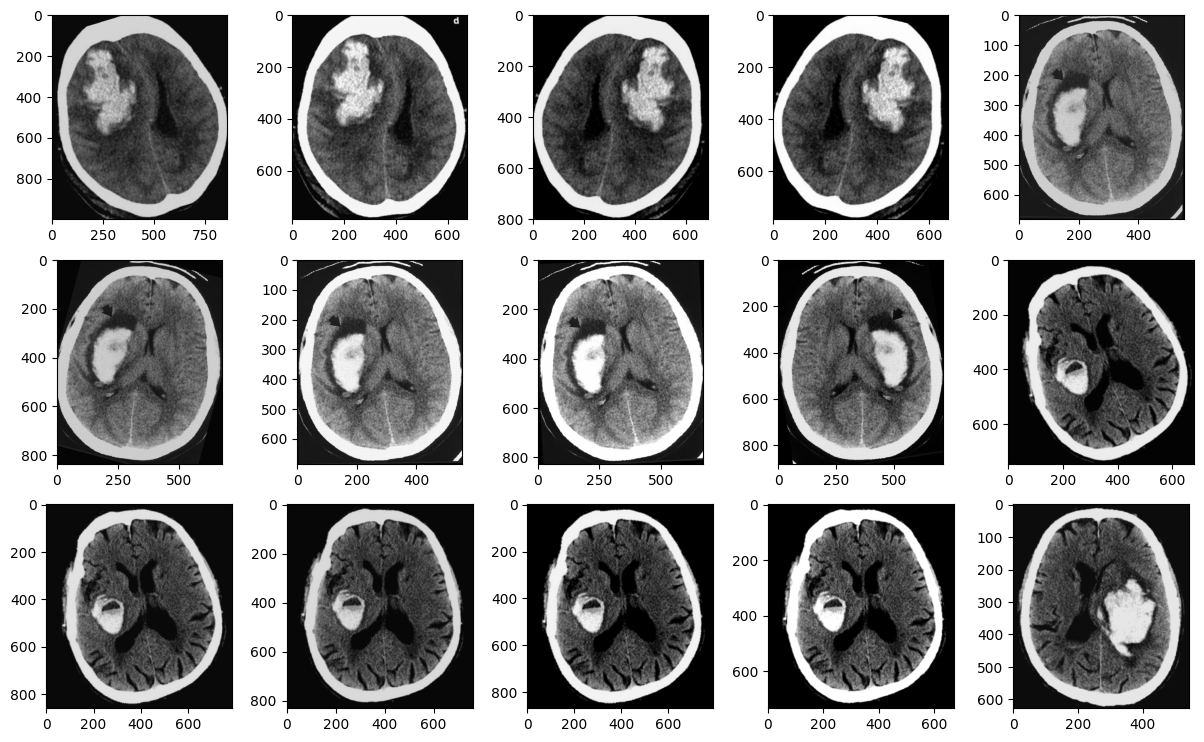

In [14]:
# Display example of augmented images with hemorrhage
hemorrhage = augmented_labels[augmented_labels['hemorrhage'] == 1]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(augmented_images[hemorrhage.index[i]], cmap='gray')
plt.show()

## INFO FOR MODELING AND EVALUATION, THEN DELETE:
`images` = paths to images
`labels` = `pd.DataFrame` with `id` and `hemorrhage` columns

`augmented_images` = np.array
`augmented_labels` = `pd.DataFrame` with `id` and `hemorrhage` columns

augmented are synthetic and should be **used only for training**

## 4.2 Modeling and Evaluation

First we change the pictures to numpy arrays, and then we split them between test/train.

In [15]:
x = []
y = []
IMG_SIZE = 224 # supposedly standard size..

for idx, path in enumerate(images):
    # loading
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    #normalizing
    img = img.astype('float32') / 255.0 # values should be about 0.5 so it is between 0 and 1, original was 128
    
    x.append(img)
    y.append(labels.iloc[idx]['hemorrhage'])


In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2, 
    random_state=20,
    stratify=y 
)

First we will try the Logistic Regression model and see what the Accuracy, precision and recall stats are for that.

In [17]:
x_train = np.array(x_train)
x_test  = np.array(x_test)

x_train_flat = x_train.reshape(len(x_train), -1)
x_test_flat  = x_test.reshape(len(x_test), -1)

log_reg = LogisticRegression(max_iter=1000, random_state=23)
log_reg.fit(x_train_flat, y_train)

y_pred_train = log_reg.predict(x_train_flat)
y_pred_test = log_reg.predict(x_test_flat)


In [18]:
print("Logistic Regression")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Test Precision:", precision_score(y_test, y_pred_test))
print("Test Recall:", recall_score(y_test, y_pred_test))

Logistic Regression
Train Accuracy: 1.0
Test Accuracy: 0.8
Test Precision: 0.7727272727272727
Test Recall: 0.85


Next model we will try is Random Forest.

In [19]:
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,
    random_state=20
)

rf.fit(x_train_flat, y_train)

,n_estimators,50
,criterion,'gini'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
rf_prediction_test = rf.predict(x_test_flat)
rf_prediction_train = rf.predict(x_train_flat)

In [21]:
rf_test_accuracy = accuracy_score(y_test, rf_prediction_test)
rf_test_precision = precision_score(y_test, rf_prediction_test)
rf_test_recall = recall_score(y_test, rf_prediction_test)

rf_train_accuracy = accuracy_score(y_train, rf_prediction_train)
rf_train_precision = precision_score(y_train, rf_prediction_train)
rf_train_recall = recall_score(y_train, rf_prediction_train)

In [22]:
print("Random Forest")
print("Train Accuracy:", accuracy_score(y_train, rf_prediction_train))
print("Test Accuracy:", accuracy_score(y_test, rf_prediction_test))
print("Test Precision:", precision_score(y_test, rf_prediction_test))
print("Test Recall:", recall_score(y_test, rf_prediction_test))

Random Forest
Train Accuracy: 0.96875
Test Accuracy: 0.825
Test Precision: 0.782608695652174
Test Recall: 0.9


The overfitting is still very high, although a bit better than in Logistic regression. 

Lets check one more model and see which of the three is the best one.

As our last model, we chose CNN. 